# Bandgap Prediction

Using QM9 data set to predict the bandgap of molecules using LSTM and GNN's

In [45]:
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader as GraphDataLoader
import torch
import torch.nn as nn
import itertools
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from torch_geometric.data import Data
from torch.utils.data import DataLoader
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.utils import scatter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset

In [3]:
def load_qm9(path="./QM9"):
    return QM9(path)

qm9 = load_qm9()
smiles = []
coords = []
homo_lumo_gaps = []
stock_gap = []
homo = []
lumo = []

for entry in qm9:
    smiles.append(entry.smiles)  # Get SMILES notation
    coords.append(entry.pos)     # Get atomic coordinates
    homo_energy = entry.y[0, 2].item()  # Get HOMO energy from the tensor
    homo.append(homo_energy)
    lumo_energy = entry.y[0, 3].item()  # Get LUMO energy from the tensor
    lumo.append(lumo_energy)
    gap_stock = entry.y[0, 4].item() 
    gap = lumo_energy - homo_energy  # Calculate the bandgap
    stock_gap.append(gap_stock)
    homo_lumo_gaps.append(gap)  # Store the bandgap
# Creating a DataFrame for better visualization and handling
qm9_data = pd.DataFrame({
    "SMILES": smiles,
    "Coordinates": coords,
    "HOMO" : homo,
    "LUMO" : lumo,
    "Egap" : stock_gap
})

# Print the first few rows of the DataFrame to verify
print(qm9_data.head())

              SMILES                                        Coordinates  \
0  [H]C([H])([H])[H]  [[tensor(-0.0127), tensor(1.0858), tensor(0.00...   
1       [H]N([H])[H]  [[tensor(-0.0404), tensor(1.0241), tensor(0.06...   
2            [H]O[H]  [[tensor(-0.0344), tensor(0.9775), tensor(0.00...   
3          [H]C#C[H]  [[tensor(0.5995), tensor(0.), tensor(1.)], [te...   
4             [H]C#N  [[tensor(-0.0133), tensor(1.1325), tensor(0.00...   

        HOMO      LUMO       Egap  
0 -10.549854  3.186453  13.736308  
1  -6.993326  2.255824   9.249149  
2  -7.967494  1.869422   9.836916  
3  -7.741639  1.376896   9.118535  
4  -9.806983  0.519737  10.329442  


In [6]:
print(qm9[0])

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])


In [83]:
def pad_start_end_token(smiles):
    """
    Pad a list of SMILES with "SOS" and "EOS" token
    
    Parameters
    ----------
    smiles: list of str
        A list containing SMILES strings to pad
    
    Returns
    ------
    padded: list of list of str
        A list containing padded SMILES strings. Example: [['SOS', 'C', 'EOS'], ...]
    """
    padded = []
    for smile in smiles:
        padded.append(['SOS'] + list(smile) + ['EOS'])
    
    return padded

In [84]:
padded_smiles = pad_start_end_token(qm9_data["SMILES"])
vocab = np.unique(np.concatenate(padded_smiles))

In [85]:
class SmilesDataset(Dataset):
    def __init__(self, smiles, vocab, y):
        
        self.vocab = np.array(vocab, dtype=str).reshape(-1, 1)
        
        self.encoder = OneHotEncoder()
        # fit the encoder
        self.encoder.fit(self.vocab)

        self.y = y
        
        # one-hot encoding
        self.data = [
            torch.tensor(
                self.encoder.transform(np.array(s).reshape(-1, 1)).toarray(),
                dtype=torch.float
            ) for s in smiles
        ]
        
        self.data = nn.utils.rnn.pad_sequence(self.data, batch_first=True)
        self.X = self.data[:, :-1, :]
        
    def __len__(self):
        return int(self.data.shape[0])
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [86]:
data_homo = SmilesDataset(padded_smiles, vocab, qm9_data["HOMO"])
data_homo_lite = SmilesDataset(padded_smiles[:50000], vocab, qm9_data["HOMO"][:50000])

data_lumo = SmilesDataset(padded_smiles, vocab, qm9_data["LUMO"])
data_lumo_lite = SmilesDataset(padded_smiles[:50000], vocab, qm9_data["LUMO"][:50000])
input_size = data_homo.vocab.shape[0] 

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

     
class Trainer:
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        if opt_method == "sgdm":
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        elif opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
        
    
    def train(self, train_data, draw_curve=True):
        self.encoder = train_data.encoder
        
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        train_loss_list, train_acc_list = [], []
        
        loss_func = nn.L1Loss()
        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss, epoch_err = 0.0, 0.0
            for X_batch, y_batch in train_loader:
                batch_importance = y_batch.shape[0] / len(train_data)
                y_pred, _ = self.model(X_batch)
                batch_loss = loss_func(y_pred.flatten(), y_batch.float())
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_err = torch.mean(y_batch.float() ** 2 - y_pred.flatten() ** 2)
            
                epoch_err += batch_err.detach().cpu().item() * batch_importance
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
            
            train_acc_list.append(epoch_err)
            train_loss_list.append(epoch_loss)
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].set_title("Error")
            axes[1].legend()
    
    def sample(self, num_seq=10):
        self.model.eval()
        seqs = []
        with torch.no_grad():
            for _ in tqdm(range(num_seq), leave=False):
                chars = ['SOS']
                hidden = self.model.init_hidden(1)
                while chars[-1] != 'EOS':
                    input_encoding = self.encoder.transform(np.array([chars[-1]]).reshape(-1, 1)).toarray()
                    input_encoding = torch.tensor(input_encoding, dtype=torch.float).reshape(1, 1, -1)
                    out, hidden = self.model(input_encoding, hidden)

                    prob = out.detach().numpy().flatten()
                    prob /= np.sum(prob)

                    index = np.random.choice(self.model.input_size, p=prob)
                    out_encoding = np.zeros((1, self.model.input_size))
                    out_encoding[0, index] = 1.0
                    char = data.encoder.inverse_transform(out_encoding).flatten().tolist()[0]
                    chars.append(char)
                seqs.append(''.join(chars[1:-1]))
        return seqs

In [88]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers=1):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h=None):
        out, h = self.lstm(x, h)
        out = out[:, -1, :]

        out = self.fc(out)
        return out, h
        

    def predict(self, x):
        # Check if the input tensor has the right number of dimensions
        if x.ndim != 3:
            raise ValueError(f"Expected input to be a 3D tensor, got {x.ndim}D tensor instead.")

        self.eval()  # Ensure the model is in eval mode
        with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
            h = self.init_hidden(x.size(0))
            out, _ = self.forward(x, h)
            out = out.squeeze()  # Remove the batch dimension if batch_size == 1

            return out
        
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size), 
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

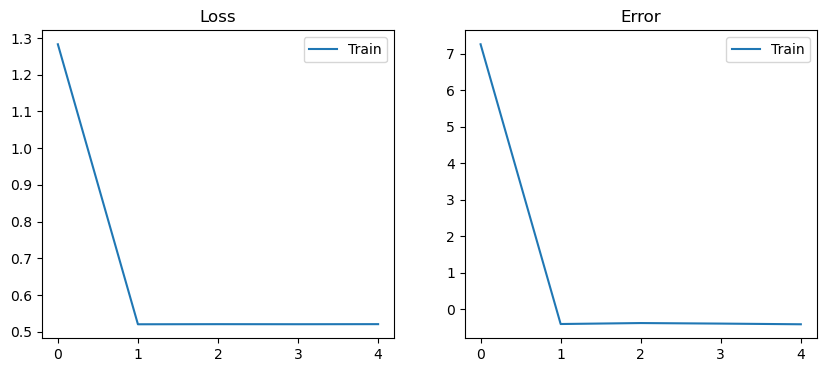

In [89]:
model_homo = LSTM(input_size, 1, 32, 2)
model_lumo = LSTM(input_size, 1, 32, 2)
trainer_homo = Trainer(model_homo, "adam", 1e-3, 128, 5, 1e-5)
trainer_lumo = Trainer(model_lumo, "adam", 1e-3, 128, 5, 1e-5)

trainer_homo.train(data_homo_lite)


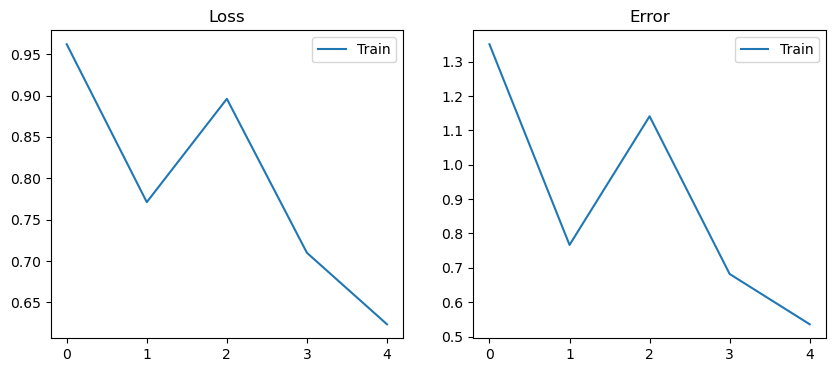

In [90]:
trainer_lumo.train(data_lumo_lite)

In [92]:
target_homo = qm9_data["HOMO"][0]
target_lumo = qm9_data["LUMO"][0]
# print([data_homo[50001][0]])
# print(torch.tensor([data_homo[50001][0]]))
# model_homo.predict(torch.tensor([data_homo[50001][0]]))
model_homo.predict(torch.tensor(data_homo[50001][0]).unsqueeze(0))

/var/folders/0z/n9w742pd3bx5nnd8vs21vzf80000gp/T/ipykernel_81445/1050370127.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_homo.predict(torch.tensor(data_homo[50001][0]).unsqueeze(0))


tensor(-6.5593)

MLP

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Fully connected layer 1
        self.fc2 = nn.Linear(hidden_size, output_size)  # Fully connected layer 2

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU activation to the output of the first layer
        x = self.fc2(x)  # Output layer
        return x

# Example usage:
# Define input size, hidden size, and output size
input_size = 10
hidden_size = 20
output_size = 5

# Create an instance of the MLP model
model = MLP(input_size, hidden_size, output_size)

# Create some dummy input data
x = torch.randn(32, input_size)  # Assuming a batch size of 32

# Forward pass
output = model(x)

# Print the output shape
print("Output shape:", output.shape)


THIS DID NOT WORK - MIGHT COME BACK LATER...

We got the code to process the SMILE strings into a graph from here: https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/\

In [9]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding

In [14]:
def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

In [15]:
def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

In [36]:
def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue

        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))

        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
            
        X = torch.tensor(X, dtype = torch.float)
        
        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)
        
        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))
        
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        
        EF = torch.tensor(EF, dtype = torch.float)
        
        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
        
        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

    return data_list

In [47]:
qm9_data_clean = qm9_data.dropna(subset=["SMILES", "Egap"])
smiles = qm9_data_clean["SMILES"]
gap = qm9_data_clean["Egap"]
gnn_data_pre = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(smiles[0:100], gap[0:100])


In [ ]:
torch.tensor()

In [71]:
arr = np.array([])
for data in gnn_data_pre:
    arr = np.append(arr, data)

arr

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4, 2) + inhomogeneous part.

In [62]:
with open('./Data/GNNDATA', 'w+') as f:
     
    for items in gnn_data_pre:
        f.write('%s\n' %items)
     


In [66]:
from torch_geometric.data import Data

# Load your data from the file
data_file = './Data/GNNDATA'
# Assuming your data is stored as numpy arrays in a file, you can load it like this:
x = torch.tensor(np.array(gnn_data_pre), dtype=torch.float)  # Node features
edge_index = torch.tensor(np.load(data_file + '_edges.npy'), dtype=torch.long)  # Edge connectivity
y = torch.tensor(np.load(data_file + '_labels.npy'), dtype=torch.long)  # Node labels

# Create a PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (100, 4, 2) + inhomogeneous part.

GNN Architecture (from HW9)

In [43]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(gnn_data.num_node_features, 16)
        self.conv2 = GCNConv(16, gnn_data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [44]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(gnn_data)
    loss = F.nll_loss(out[gnn_data.train_mask], gnn_data.y[gnn_data.train_mask])
    loss.backward()
    optimizer.step()

AttributeError: 'list' object has no attribute 'num_node_features'